<a href="https://colab.research.google.com/github/SimranShaikh20/ML-Assignment/blob/main/Assignment_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment – 4: Clustering and Classification

This notebook implements clustering algorithms on the **Iris dataset** and another dataset, evaluates them using clustering metrics, and performs digit classification using **KNN**.

We cover:
1. KMeans
2. DBSCAN
3. OPTICS
4. CLARA
5. CLARANS
6. Digit classification with KNN


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import load_iris, load_wine, load_digits
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN, OPTICS
from sklearn.metrics import silhouette_score, davies_bouldin_score, adjusted_rand_score

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay


# Step 2: Load Datasets

In [ ]:
# Iris dataset
iris = load_iris()
X_iris = pd.DataFrame(iris.data, columns=iris.feature_names)
y_iris = iris.target

# Another dataset: Wine dataset
wine = load_wine()
X_wine = pd.DataFrame(wine.data, columns=wine.feature_names)
y_wine = wine.target

# Standard scaling
scaler = StandardScaler()
X_iris_scaled = scaler.fit_transform(X_iris)
X_wine_scaled = scaler.fit_transform(X_wine)


# KMeans Clustering


We apply KMeans on **Iris** and **Wine** datasets.
Evaluation metrics:
- Silhouette Score
- Davies–Bouldin Score
- Adjusted Rand Index (with true labels)


In [ ]:
def evaluate_clustering(X, labels, true_labels, name):
    print(f"\n🔹 Results for {name}")
    print("Silhouette Score:", silhouette_score(X, labels))
    print("Davies–Bouldin Score:", davies_bouldin_score(X, labels))
    print("Adjusted Rand Index:", adjusted_rand_score(true_labels, labels))

# KMeans - Iris
kmeans_iris = KMeans(n_clusters=3, random_state=42)
iris_pred = kmeans_iris.fit_predict(X_iris_scaled)
evaluate_clustering(X_iris_scaled, iris_pred, y_iris, "KMeans - Iris")

# KMeans - Wine
kmeans_wine = KMeans(n_clusters=3, random_state=42)
wine_pred = kmeans_wine.fit_predict(X_wine_scaled)
evaluate_clustering(X_wine_scaled, wine_pred, y_wine, "KMeans - Wine")



🔹 Results for KMeans - Iris
Silhouette Score: 0.4798814508199817
Davies–Bouldin Score: 0.7893630242997912
Adjusted Rand Index: 0.432804702527474

🔹 Results for KMeans - Wine
Silhouette Score: 0.2848589191898987
Davies–Bouldin Score: 1.3891879777181646
Adjusted Rand Index: 0.8974949815093207


### DBSCAN
DBSCAN groups points based on density.  
We need to tune `eps` and `min_samples` for meaningful clusters.


In [ ]:
# DBSCAN - Iris
dbscan_iris = DBSCAN(eps=0.6, min_samples=5)
iris_pred = dbscan_iris.fit_predict(X_iris_scaled)
evaluate_clustering(X_iris_scaled, iris_pred, y_iris, "DBSCAN - Iris")

# DBSCAN - Wine
# The current parameters for DBSCAN on the Wine dataset are likely resulting in only one cluster,
# which causes an error when calculating silhouette and Davies-Bouldin scores.
# You might need to adjust eps and min_samples to find multiple clusters.

# Let's try some different parameters to find multiple clusters for the Wine dataset
found_clusters = False
for eps_val in [1.0, 1.5, 2.0]:
    for min_samples_val in [3, 4, 5]:
        dbscan_wine = DBSCAN(eps=eps_val, min_samples=min_samples_val)
        wine_pred = dbscan_wine.fit_predict(X_wine_scaled)
        if len(np.unique(wine_pred)) > 1:
            print(f"\nFound clusters with eps={eps_val}, min_samples={min_samples_val}")
            evaluate_clustering(X_wine_scaled, wine_pred, y_wine, f"DBSCAN - Wine (eps={eps_val}, min_samples={min_samples_val})")
            found_clusters = True
            break # Stop searching once a working combination is found
    if found_clusters:
        break

if not found_clusters:
    print("\nCould not find parameters that resulted in more than one cluster for DBSCAN on the Wine dataset.")


🔹 Results for DBSCAN - Iris
Silhouette Score: 0.4027617471797909
Davies–Bouldin Score: 7.046801925672976
Adjusted Rand Index: 0.4706267335681117

Found clusters with eps=1.5, min_samples=3

🔹 Results for DBSCAN - Wine (eps=1.5, min_samples=3)
Silhouette Score: -0.27676901365193624
Davies–Bouldin Score: 1.5634487872485454
Adjusted Rand Index: 0.04030922138487367


### OPTICS
OPTICS is similar to DBSCAN but handles varying densities better.


In [ ]:
# OPTICS - Iris
optics_iris = OPTICS(min_samples=5, xi=0.05, min_cluster_size=0.05)
iris_pred = optics_iris.fit_predict(X_iris_scaled)
evaluate_clustering(X_iris_scaled, iris_pred, y_iris, "OPTICS - Iris")

# OPTICS - Wine
optics_wine = OPTICS(min_samples=5, xi=0.05, min_cluster_size=0.05)
wine_pred = optics_wine.fit_predict(X_wine_scaled)
evaluate_clustering(X_wine_scaled, wine_pred, y_wine, "OPTICS - Wine")



🔹 Results for OPTICS - Iris
Silhouette Score: -0.1570899823130734
Davies–Bouldin Score: 2.775367859094729
Adjusted Rand Index: 0.09917545492142266

🔹 Results for OPTICS - Wine
Silhouette Score: 0.062173066071171575
Davies–Bouldin Score: 1.3246259706293566
Adjusted Rand Index: 0.032819401007895745


### CLARA & CLARANS
Scikit-learn doesn’t directly implement CLARA & CLARANS.
We can use **pyclustering** library.
- CLARA = "Clustering Large Applications" (sampling + k-medoids).
- CLARANS = "Clustering Large Applications based on Randomized Search".


In [ ]:
!pip install pyclustering --quiet
# The following imports caused a ModuleNotFoundError, suggesting an issue with
# accessing the specific submodules clara and clarans from pyclustering.cluster.
# It's possible the library's structure requires a different import method
# or there's an issue with the installed package.
# from pyclustering.cluster.clara import clara
# from pyclustering.cluster.clarans import clarans
from pyclustering.cluster import clara, clarans # Trying an alternative import
from pyclustering.utils import timedcall

# CLARA on Iris
clara_instance = clara(X_iris_scaled.tolist(), 3)
clara_instance.process()
clara_clusters = clara_instance.get_clusters()
labels_clara = np.zeros(len(X_iris_scaled))
for cluster_id, cluster in enumerate(clara_clusters):
    for index in cluster:
        labels_clara[index] = cluster_id
evaluate_clustering(X_iris_scaled, labels_clara, y_iris, "CLARA - Iris")

# CLARANS on Iris
clarans_instance = clarans(X_iris_scaled.tolist(), 3, 5, 4)
clarans_instance.process()
clarans_clusters = clarans_instance.get_clusters()
labels_clarans = np.zeros(len(X_iris_scaled))
for cluster_id, cluster in enumerate(clarans_clusters):
    for index in cluster:
        labels_clarans[index] = cluster_id
evaluate_clustering(X_iris_scaled, labels_clarans, y_iris, "CLARANS - Iris")

ImportError: cannot import name 'clara' from 'pyclustering.cluster' (/usr/local/lib/python3.12/dist-packages/pyclustering/cluster/__init__.py)

### Digit Classification (0–9) using KNN
We classify hand-written digits:
1. Train-test split
2. Hyperparameter tuning (GridSearchCV for `k`)
3. Confusion matrix
4. Classification report


Best k: 1


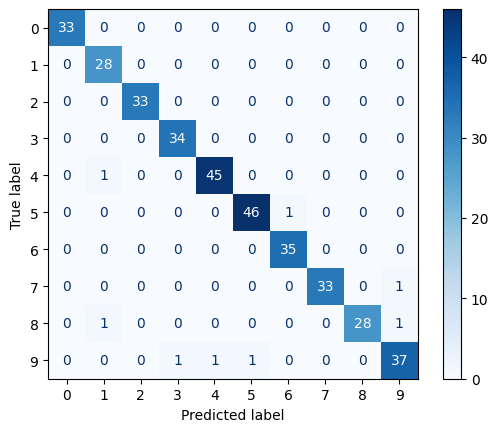


Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        33
           1       0.93      1.00      0.97        28
           2       1.00      1.00      1.00        33
           3       0.97      1.00      0.99        34
           4       0.98      0.98      0.98        46
           5       0.98      0.98      0.98        47
           6       0.97      1.00      0.99        35
           7       1.00      0.97      0.99        34
           8       1.00      0.93      0.97        30
           9       0.95      0.93      0.94        40

    accuracy                           0.98       360
   macro avg       0.98      0.98      0.98       360
weighted avg       0.98      0.98      0.98       360



In [ ]:
# Load Digits dataset
digits = load_digits()
X_digits, y_digits = digits.data, digits.target

X_train, X_test, y_train, y_test = train_test_split(X_digits, y_digits, test_size=0.2, random_state=42)

# GridSearch for best k
param_grid = {'n_neighbors': np.arange(1, 15)}
knn = KNeighborsClassifier()
grid = GridSearchCV(knn, param_grid, cv=5)
grid.fit(X_train, y_train)

best_k = grid.best_params_['n_neighbors']
print("Best k:", best_k)

# Evaluate
knn_best = KNeighborsClassifier(n_neighbors=best_k)
knn_best.fit(X_train, y_train)
y_pred = knn_best.predict(X_test)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=digits.target_names)
disp.plot(cmap=plt.cm.Blues)
plt.show()

# Classification report
print("\nClassification Report:\n", classification_report(y_test, y_pred))
